In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

### 1. Чтение и преобразования данных для лабораторной 

In [104]:
data = pd.read_csv("data/lab4/data.csv",index_col="Id")
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Оставим в данных только жилую недвижимость, для этого отфильтруем колонку MSZoning. Оставив только следующие
поля:
- RH-Жилая недвижимость с высокой плотностью застройки
- RL-Жилая недвижимость с низкой плотностью застройки
- RP-Жилой парк с низкой плотностью застройки 
- RM-Жилая недвижимость со средней плотностью застройки 
После чего удалим колонку MSZoning, так как датасета будет состоять только из жилой недвижимости

In [105]:
data = data[
    (data["MSZoning"] == "RH")
    | (data["MSZoning"] == "RL")
    | (data["MSZoning"] == "RP")
    | (data["MSZoning"] == "RM")
]
data = data.drop(columns="MSZoning",axis=0)
data.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


После того, как получили датасет только с жилыми домами, нужно проверить все переменные на наличие NaN.

In [106]:
columns_name__with_nan_value = list(data.columns[data.isna().any()])
for column_name in columns_name__with_nan_value:
    print(
        f"В колонке {column_name} есть значения NaN. Тип данных в колонке {data[column_name].dtype}."
    )

В колонке LotFrontage есть значения NaN. Тип данных в колонке float64.
В колонке Alley есть значения NaN. Тип данных в колонке object.
В колонке MasVnrType есть значения NaN. Тип данных в колонке object.
В колонке MasVnrArea есть значения NaN. Тип данных в колонке float64.
В колонке BsmtQual есть значения NaN. Тип данных в колонке object.
В колонке BsmtCond есть значения NaN. Тип данных в колонке object.
В колонке BsmtExposure есть значения NaN. Тип данных в колонке object.
В колонке BsmtFinType1 есть значения NaN. Тип данных в колонке object.
В колонке BsmtFinType2 есть значения NaN. Тип данных в колонке object.
В колонке Electrical есть значения NaN. Тип данных в колонке object.
В колонке FireplaceQu есть значения NaN. Тип данных в колонке object.
В колонке GarageType есть значения NaN. Тип данных в колонке object.
В колонке GarageYrBlt есть значения NaN. Тип данных в колонке float64.
В колонке GarageFinish есть значения NaN. Тип данных в колонке object.
В колонке GarageQual есть зна

Так колонки в которых содержаться значения NaN, имееют разный тип, то стратегия востановлений значений будет разная.
Описания стратегии: 
- LotFrontage -  Линейный отрезок улицы, соединенный с объектом недвижимости. То есть значение NaN будем менять на 0.
- Alley - Тип подъездной аллеи к объекту недвижимости. В описание датасета, сказано, что отсутвсие подъезда имеет значени NA, тогда NaN заменим на NA.
- MasVnrType -  Тип облицовки каменной кладки. Если облицовки нет, то значение должно быть None, тогда заменим NaN на None.
- MasVnrArea - Площадь облицовочной части. При проверек было выснено, что в случае, если площадь равна NaN, тип облицовки тоже NaN, тогда если площадь равна NaN, ее можно спокойно менять на 0. Скрин проверки  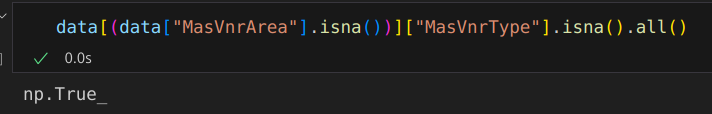
- BsmtQual - Высоту подвала. Заменим NaN на  NA.
- BsmtCond - Состояние подвала. При проверке было выяснено, что в случае, когда состояние подвала NaN, высота подвала тоже NaN, тогда заменим все NaN на NA. Скрин проверки 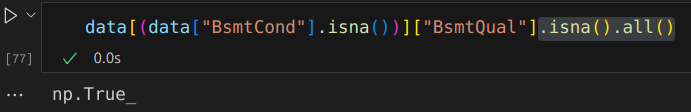
- Electrical system - Электрическая сиситема . Так как невозможно предположить о том, какая система стоитЮ то добавим новую категорию NA.
- FireplaceQu - Качество камина. Если стоит NaN заменим на NA.
- GarageType - Тип гаража.Если стоит NaN заменим на NA.
- GarageYrBlt - Год постройки гаража. В случае, если год постройки NaN, то тип гаража тоже NaN, тогда заменим год потсройки на 1.
- GarageFinish - Состояние гаража. NaN заменим на NA. Так как все значения NaN для качество имеют 
- GarageQual - Качестов гоража. NaN заменим на NA.
- PoolQC - Качество бассейна. NaN заменим на NA. 
- Fence - Качество безопасности забора. NaN заменим на NA.
- MiscFeature - Дополнительные условия. Если NaN заменим на NA.

In [107]:
data = data.drop(columns="GarageCond")
columns_name__with_nan_value.remove("GarageCond")
num_cols = data.select_dtypes(include=[np.int64])
data["MasVnrArea"] = data["MasVnrArea"].replace(np.nan, 0)
data["LotFrontage"] = data["LotFrontage"].replace(np.nan, 0)
data["GarageYrBlt"] = data["GarageYrBlt"].replace(np.nan)
for column_name in columns_name__with_nan_value:
    if data[column_name].dtype == type(np.dtypes.ObjectDType):
        data[column_name] = data[column_name].replace(np.nan, "NA")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1385 entries, 1 to 1460
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1385 non-null   int64  
 1   LotFrontage    1385 non-null   float64
 2   LotArea        1385 non-null   int64  
 3   Street         1385 non-null   object 
 4   Alley          1385 non-null   object 
 5   LotShape       1385 non-null   object 
 6   LandContour    1385 non-null   object 
 7   Utilities      1385 non-null   object 
 8   LotConfig      1385 non-null   object 
 9   LandSlope      1385 non-null   object 
 10  Neighborhood   1385 non-null   object 
 11  Condition1     1385 non-null   object 
 12  Condition2     1385 non-null   object 
 13  BldgType       1385 non-null   object 
 14  HouseStyle     1385 non-null   object 
 15  OverallQual    1385 non-null   int64  
 16  OverallCond    1385 non-null   int64  
 17  YearBuilt      1385 non-null   int64  
 18  YearRemodAdd 

/tmp/ipykernel_8594/3359349990.py:6: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  data["GarageYrBlt"] = data["GarageYrBlt"].replace(np.nan)


Теперь в датасете нет NaN значений

### 2. Для проведения регрессионного анализа необходимо преобразовать исходные данные и представить их в виде таблицы

Переведем категориальные переменные в числовые, воспользуемся глупым способом - LabelEncoding, Из библиотеки sklearn.

In [108]:
le = LabelEncoder()
for column_name in data.columns:
    if data[column_name].dtype == type(np.dtypes.ObjectDType):
        data[column_name] = le.fit_transform(data[column_name])
data

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,1,1,3,3,0,4,0,...,0,3,4,1,0,2,2008,8,4,208500
2,20,80.0,9600,1,1,3,3,0,2,0,...,0,3,4,1,0,5,2007,8,4,181500
3,60,68.0,11250,1,1,0,3,0,4,0,...,0,3,4,1,0,9,2008,8,4,223500
4,70,60.0,9550,1,1,0,3,0,0,0,...,0,3,4,1,0,2,2006,8,0,140000
5,60,84.0,14260,1,1,0,3,0,2,0,...,0,3,4,1,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,1,1,3,3,0,4,0,...,0,3,4,1,0,8,2007,8,4,175000
1457,20,85.0,13175,1,1,3,3,0,4,0,...,0,3,2,1,0,2,2010,8,4,210000
1458,70,66.0,9042,1,1,3,3,0,4,0,...,0,3,0,3,2500,5,2010,8,4,266500


### 3. Далее необходимо прологарифмировать количественные характеристики

In [109]:
for num_col in num_cols:
    data[num_col] = np.log(data[num_col])

data

/home/ivan/ЧелГУ/Анализ данных/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,4.094345,65.0,9.041922,1,1,3,3,0,4,0,...,-inf,3,4,1,-inf,0.693147,7.604894,8,4,12.247694
2,2.995732,80.0,9.169518,1,1,3,3,0,2,0,...,-inf,3,4,1,-inf,1.609438,7.604396,8,4,12.109011
3,4.094345,68.0,9.328123,1,1,0,3,0,4,0,...,-inf,3,4,1,-inf,2.197225,7.604894,8,4,12.317167
4,4.248495,60.0,9.164296,1,1,0,3,0,0,0,...,-inf,3,4,1,-inf,0.693147,7.603898,8,0,11.849398
5,4.094345,84.0,9.565214,1,1,0,3,0,2,0,...,-inf,3,4,1,-inf,2.484907,7.604894,8,4,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,4.094345,62.0,8.976768,1,1,3,3,0,4,0,...,-inf,3,4,1,-inf,2.079442,7.604396,8,4,12.072541
1457,2.995732,85.0,9.486076,1,1,3,3,0,4,0,...,-inf,3,2,1,-inf,0.693147,7.605890,8,4,12.254863
1458,4.248495,66.0,9.109636,1,1,3,3,0,4,0,...,-inf,3,0,3,7.824046,1.609438,7.605890,8,4,12.493130


Так как после логорифмирования, часть значений могли поменяться на -np.inf или np.inf, то проверим датасет на наличие таких значений.

In [110]:
res = []
for column in data.columns:
    data[column] = data[column].replace([-np.inf], 0)
    res.append(min(data[column]))
    data[column] = data[column].replace(
        +np.inf, pd.Series(data[column].unique()).sort_values(ascending=True)[1]
    )
    res.append(max(data[column]))

In [111]:
min(res)

0.0

<Axes: >

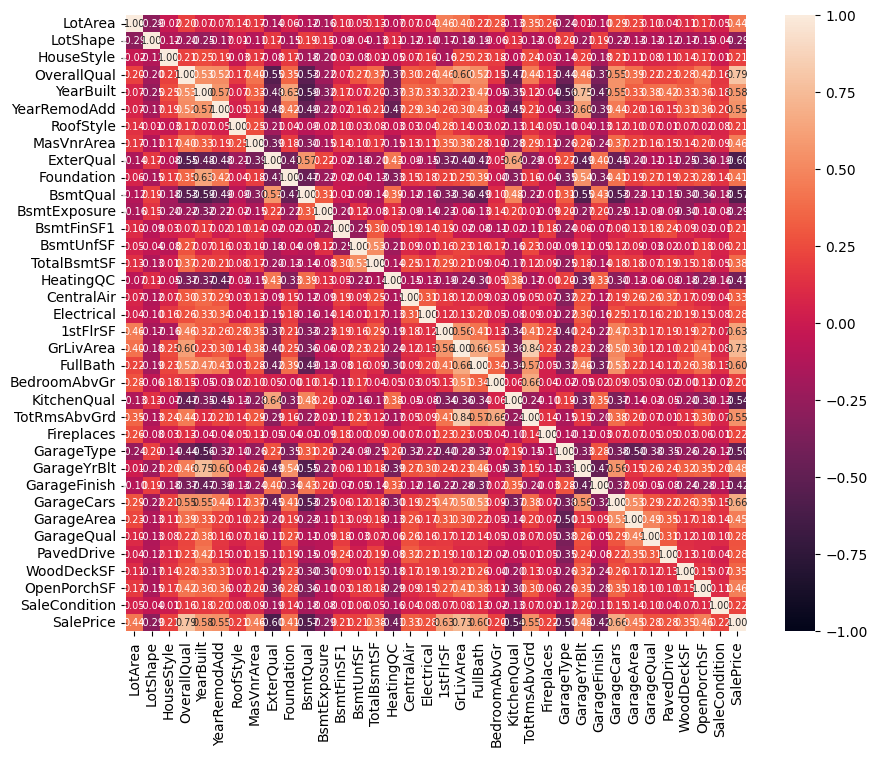

In [112]:
from matplotlib import pyplot as plt
import seaborn as sns

# Отфильтруем переменные по корреляции(если целевая переменная коррелирует меньше чем 0,2 по модолю, то неберем)
result = pd.DataFrame()
for i, v in data.corr()["SalePrice"].items():
    temp = float(v)
    if 0.2 <= abs(temp):
        result[i] = data[i]


plt.figure(figsize=(10, 8))
sns.heatmap(
    result.corr(),
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    annot_kws={"size": 7},
)


In [113]:
display(result.isnull().sum())

LotArea          0
LotShape         0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
MasVnrArea       0
ExterQual        0
Foundation       0
BsmtQual         0
BsmtExposure     0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
GrLivArea        0
FullBath         0
BedroomAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
SaleCondition    0
SalePrice        0
dtype: int64

### 4. Проводим регрессионный анализ

In [114]:
lin_reg = LinearRegression()
lin_reg.fit(result.drop(columns="SalePrice"), result["SalePrice"])
lin_reg.coef_

array([ 9.57510013e-02, -5.81841348e-03, -1.52072807e-03,  3.93053714e-01,
        1.92421792e+00,  2.96188492e+00,  8.32293863e-03,  5.17341029e-05,
       -2.68399621e-02,  9.41141065e-03, -1.12302987e-02, -8.64237384e-03,
        1.31720197e-02, -2.13513207e-03,  1.84609045e-02, -8.57485272e-03,
        8.74317355e-02,  4.37729275e-04,  6.50557660e-02,  3.41638935e-01,
        4.38508147e-03, -1.01488518e-02, -3.81158505e-02,  6.58941295e-03,
        4.50605454e-02,  1.17733341e-03, -7.64228624e-04, -6.40069248e-03,
        8.56819126e-02,  1.06142922e-02,  2.82361961e-03,  2.43563206e-02,
        3.68951743e-03,  3.30107085e-03,  2.15730064e-02])

In [116]:
for i in range(len(lin_reg.coef_)):
    print(f"Коэффициент для поля {data.columns[i]} =  {lin_reg.coef_[i]}")
print("Так  как нет коэффицинета при свободном члене, модель приравняла его к 0")

Коэффициент для поля MSSubClass =  0.09575100128972784
Коэффициент для поля LotFrontage =  -0.005818413484380435
Коэффициент для поля LotArea =  -0.0015207280749336628
Коэффициент для поля Street =  0.3930537143213227
Коэффициент для поля Alley =  1.9242179206051393
Коэффициент для поля LotShape =  2.9618849234636877
Коэффициент для поля LandContour =  0.008322938633107289
Коэффициент для поля Utilities =  5.17341029364912e-05
Коэффициент для поля LotConfig =  -0.026839962082037393
Коэффициент для поля LandSlope =  0.009411410652497868
Коэффициент для поля Neighborhood =  -0.011230298709580144
Коэффициент для поля Condition1 =  -0.00864237384188482
Коэффициент для поля Condition2 =  0.0131720197137963
Коэффициент для поля BldgType =  -0.0021351320738095046
Коэффициент для поля HouseStyle =  0.01846090450682841
Коэффициент для поля OverallQual =  -0.008574852720591674
Коэффициент для поля OverallCond =  0.08743173554241718
Коэффициент для поля YearBuilt =  0.0004377292752935832
Коэффици

In [115]:
from sklearn.metrics import r2_score

r_squared = r2_score(
    result["SalePrice"], lin_reg.predict(result.drop(columns="SalePrice"))
)
print(f"R^2 : {r_squared}")
print(
    f"Adjusted R^2 : {1 - (1-r_squared)*(len(result)-1)/(len(result)-len(data.columns))}"
)

R^2 : 0.8794986896451374
Adjusted R^2 : 0.8723995305806199
